In [1]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
# Por defecto usamos el backend inline
%matplotlib inline

# La libreta ocupa así el 95% de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

1.- Carga de datos

In [2]:
df_dosificaciones = pd.read_csv('datos/datos211008.zip', compression='zip', \
                    sep=',', na_values='\\N', index_col='codigo', \
                    parse_dates=['fecha_inicio', 'fecha_fin'])
df_dosificaciones.head(5)

,fecha_inicio,fecha_fin,cantidad_solicitada,cantidad_dosificada,mezcla,pesada,peso_inicial,manual,id_lote_destino,materia_origen,materia_destino,id_silo,tipo_materia,tipo_destino,densidad,tam_mezcla,desviacion
codigo,,,,,,,,,,,,,,,,,
1308958,2018-01-01 21:58:18,2018-01-01 22:00:15,1600.078404,1606.0,1,0,-12,0,232527,8,285,1,Prima,Formula,1,4000,5.921596
1308975,2018-01-01 22:05:50,2018-01-01 22:07:48,1600.078404,1602.0,2,0,-21,0,232527,8,285,1,Prima,Formula,1,4000,1.921596
1308987,2018-01-01 22:13:08,2018-01-01 22:15:06,1600.078404,1596.0,3,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-4.078404
1309003,2018-01-01 22:20:17,2018-01-01 22:22:15,1600.078404,1600.0,4,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-0.078404
1309022,2018-01-01 22:27:53,2018-01-01 22:29:52,1600.078404,1598.0,5,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-2.078404


2.- Exploracion de datos

In [3]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395477 entries, 1308958 to 3014892
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         395477 non-null  datetime64[ns]
 1   fecha_fin            395477 non-null  datetime64[ns]
 2   cantidad_solicitada  395477 non-null  float64       
 3   cantidad_dosificada  395477 non-null  float64       
 4   mezcla               395477 non-null  int64         
 5   pesada               395477 non-null  int64         
 6   peso_inicial         395477 non-null  int64         
 7   manual               395477 non-null  int64         
 8   id_lote_destino      395477 non-null  int64         
 9   materia_origen       395477 non-null  int64         
 10  materia_destino      395477 non-null  int64         
 11  id_silo              395477 non-null  int64         
 12  tipo_materia         395477 non-null  object        
 13  tipo_de

3.- Calculamos la duración de cada dosificación

In [4]:
df_dosificaciones['duracion'] = df_dosificaciones['fecha_fin'] - df_dosificaciones['fecha_inicio']
df_dosificaciones['duracion'] = df_dosificaciones['duracion'].dt.seconds

In [5]:
df_dosificaciones.head()

,fecha_inicio,fecha_fin,cantidad_solicitada,cantidad_dosificada,mezcla,pesada,peso_inicial,manual,id_lote_destino,materia_origen,materia_destino,id_silo,tipo_materia,tipo_destino,densidad,tam_mezcla,desviacion,duracion
codigo,,,,,,,,,,,,,,,,,,
1308958,2018-01-01 21:58:18,2018-01-01 22:00:15,1600.078404,1606.0,1,0,-12,0,232527,8,285,1,Prima,Formula,1,4000,5.921596,117
1308975,2018-01-01 22:05:50,2018-01-01 22:07:48,1600.078404,1602.0,2,0,-21,0,232527,8,285,1,Prima,Formula,1,4000,1.921596,118
1308987,2018-01-01 22:13:08,2018-01-01 22:15:06,1600.078404,1596.0,3,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-4.078404,118
1309003,2018-01-01 22:20:17,2018-01-01 22:22:15,1600.078404,1600.0,4,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-0.078404,118
1309022,2018-01-01 22:27:53,2018-01-01 22:29:52,1600.078404,1598.0,5,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-2.078404,119


4.- Calculamos el orden de cada dosificacion dentro de cada mezcla

In [6]:
df_dosificaciones = df_dosificaciones.sort_values(['codigo'])
df_dosificaciones['orden'] = 0
hskeys = {}
for key, row in df_dosificaciones.iterrows():
    hskey = str(row['mezcla'])+"-"+str(row['id_lote_destino'])+"-"+str(row['pesada'])
    valor = 0
    if (hskey in hskeys):
        valor = hskeys[hskey]
    
    hskeys[hskey] = valor + 1
    df_dosificaciones['orden'][key] = hskeys[hskey]

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [7]:
# Guardo los datos por ahorrar tiempo en posteriores pruebas
df_dosificaciones.to_csv('datos/data_parser.zip', compression='zip')

In [8]:
df_dosificaciones = pd.read_csv('datos/data_parser.zip', compression='zip', \
                    sep=',', na_values='\\N', index_col='codigo', \
                    parse_dates=['fecha_inicio', 'fecha_fin'])

In [8]:
df_dosificaciones.isnull().sum()

fecha_inicio           0
fecha_fin              0
cantidad_solicitada    0
cantidad_dosificada    0
mezcla                 0
pesada                 0
peso_inicial           0
manual                 0
id_lote_destino        0
materia_origen         0
materia_destino        0
id_silo                0
tipo_materia           0
tipo_destino           0
densidad               0
tam_mezcla             0
desviacion             0
duracion               0
orden                  0
dtype: int64

5.- Miro los valores unicos para variables con pocos valores (Todas esta columanas serán desechadas ya que no aportan gran informacion)

In [9]:
for col in df_dosificaciones:
    if (df_dosificaciones[col].nunique() < 5):
        print(col + ": ")
        print(df_dosificaciones[col].unique())

pesada: 
[0 1]
manual: 
[0]
tipo_materia: 
['Prima']
tipo_destino: 
['Formula']
densidad: 
[1]


6.- Obtengo los estadisticos de las variables numericas

In [10]:
df_dosificaciones[['cantidad_solicitada','cantidad_dosificada', \
                   'peso_inicial','tam_mezcla', 'duracion', 'desviacion']].describe()

,cantidad_solicitada,cantidad_dosificada,peso_inicial,tam_mezcla,duracion,desviacion
count,395477.000000,395477.000000,395477.000000,395477.000000,395477.000000,395477.000000
mean,801.251668,800.430925,1342.961790,4000.817393,37.613821,-0.820743
std,744.934627,745.126502,1249.587527,211.905637,37.362577,30.448675
min,0.000000,0.000000,-64.000000,400.000000,0.000000,-2623.091942
25%,167.984881,168.000000,11.000000,4000.000000,16.000000,-3.000000
50%,668.040000,664.000000,1574.000000,4000.000000,25.000000,0.004000
75%,1163.096968,1168.000000,2600.000000,4040.000000,49.000000,3.019802
max,3121.984940,3127.000000,3995.000000,4500.000000,7786.000000,1179.891694


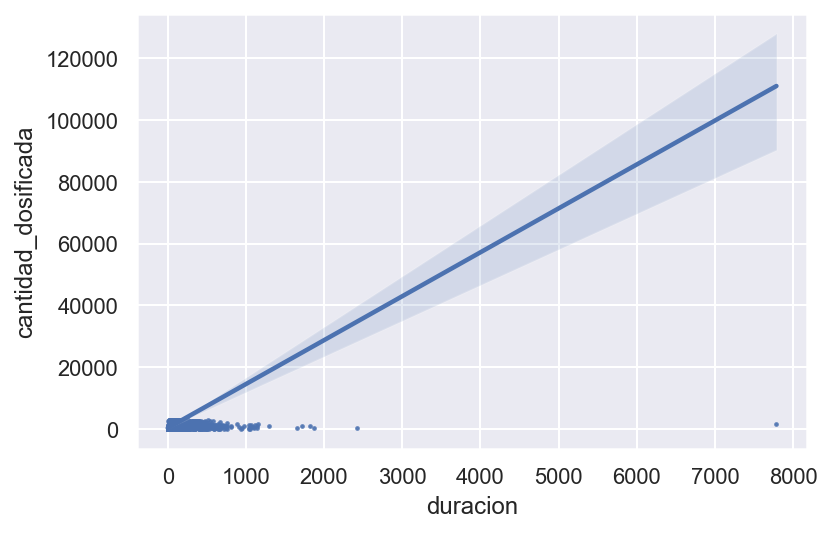

In [11]:
sns.regplot(data=df_dosificaciones, x='duracion', y='cantidad_dosificada', scatter_kws={'s':2});

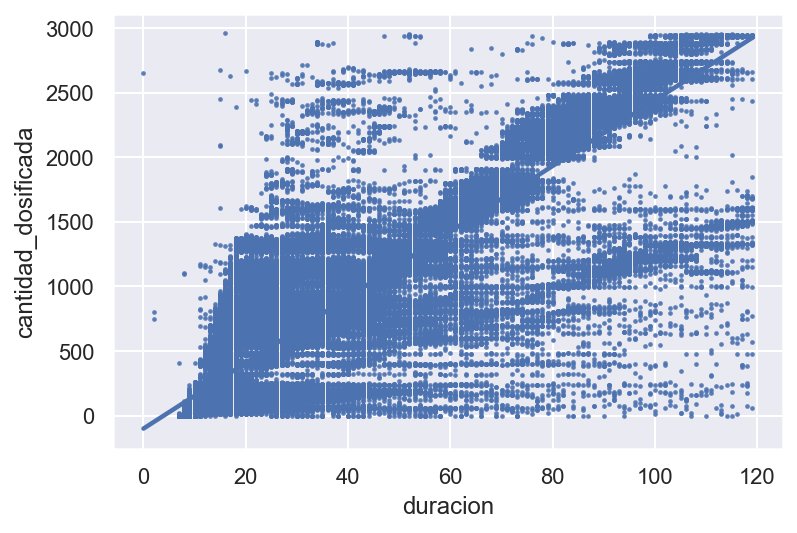

In [12]:
sns.regplot(data=df_dosificaciones[df_dosificaciones['duracion']<120], x='duracion', y='cantidad_dosificada', scatter_kws={'s':2});

In [13]:
df_dosificaciones = df_dosificaciones[df_dosificaciones['duracion']<120]

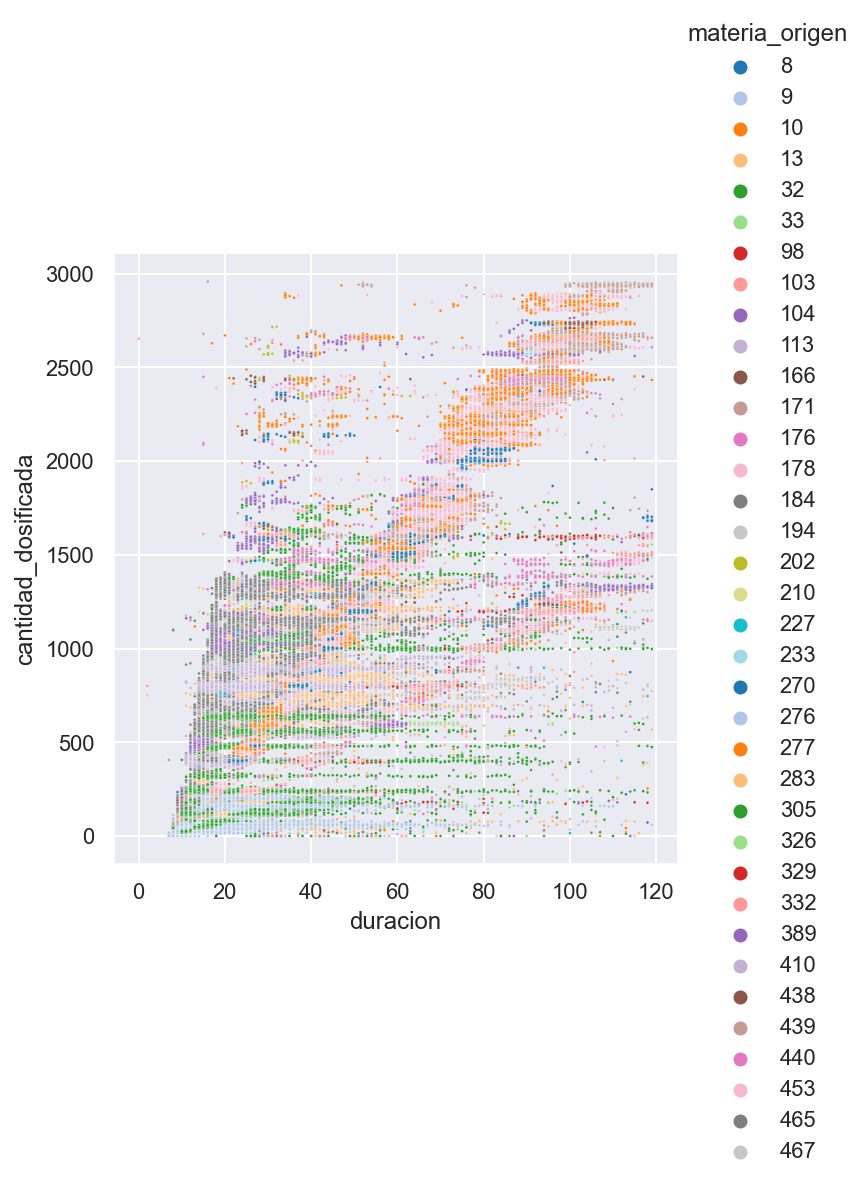

In [14]:
sns.relplot(data=df_dosificaciones, x='duracion', y='cantidad_dosificada', 
            s=2, hue='materia_origen', palette='tab20');

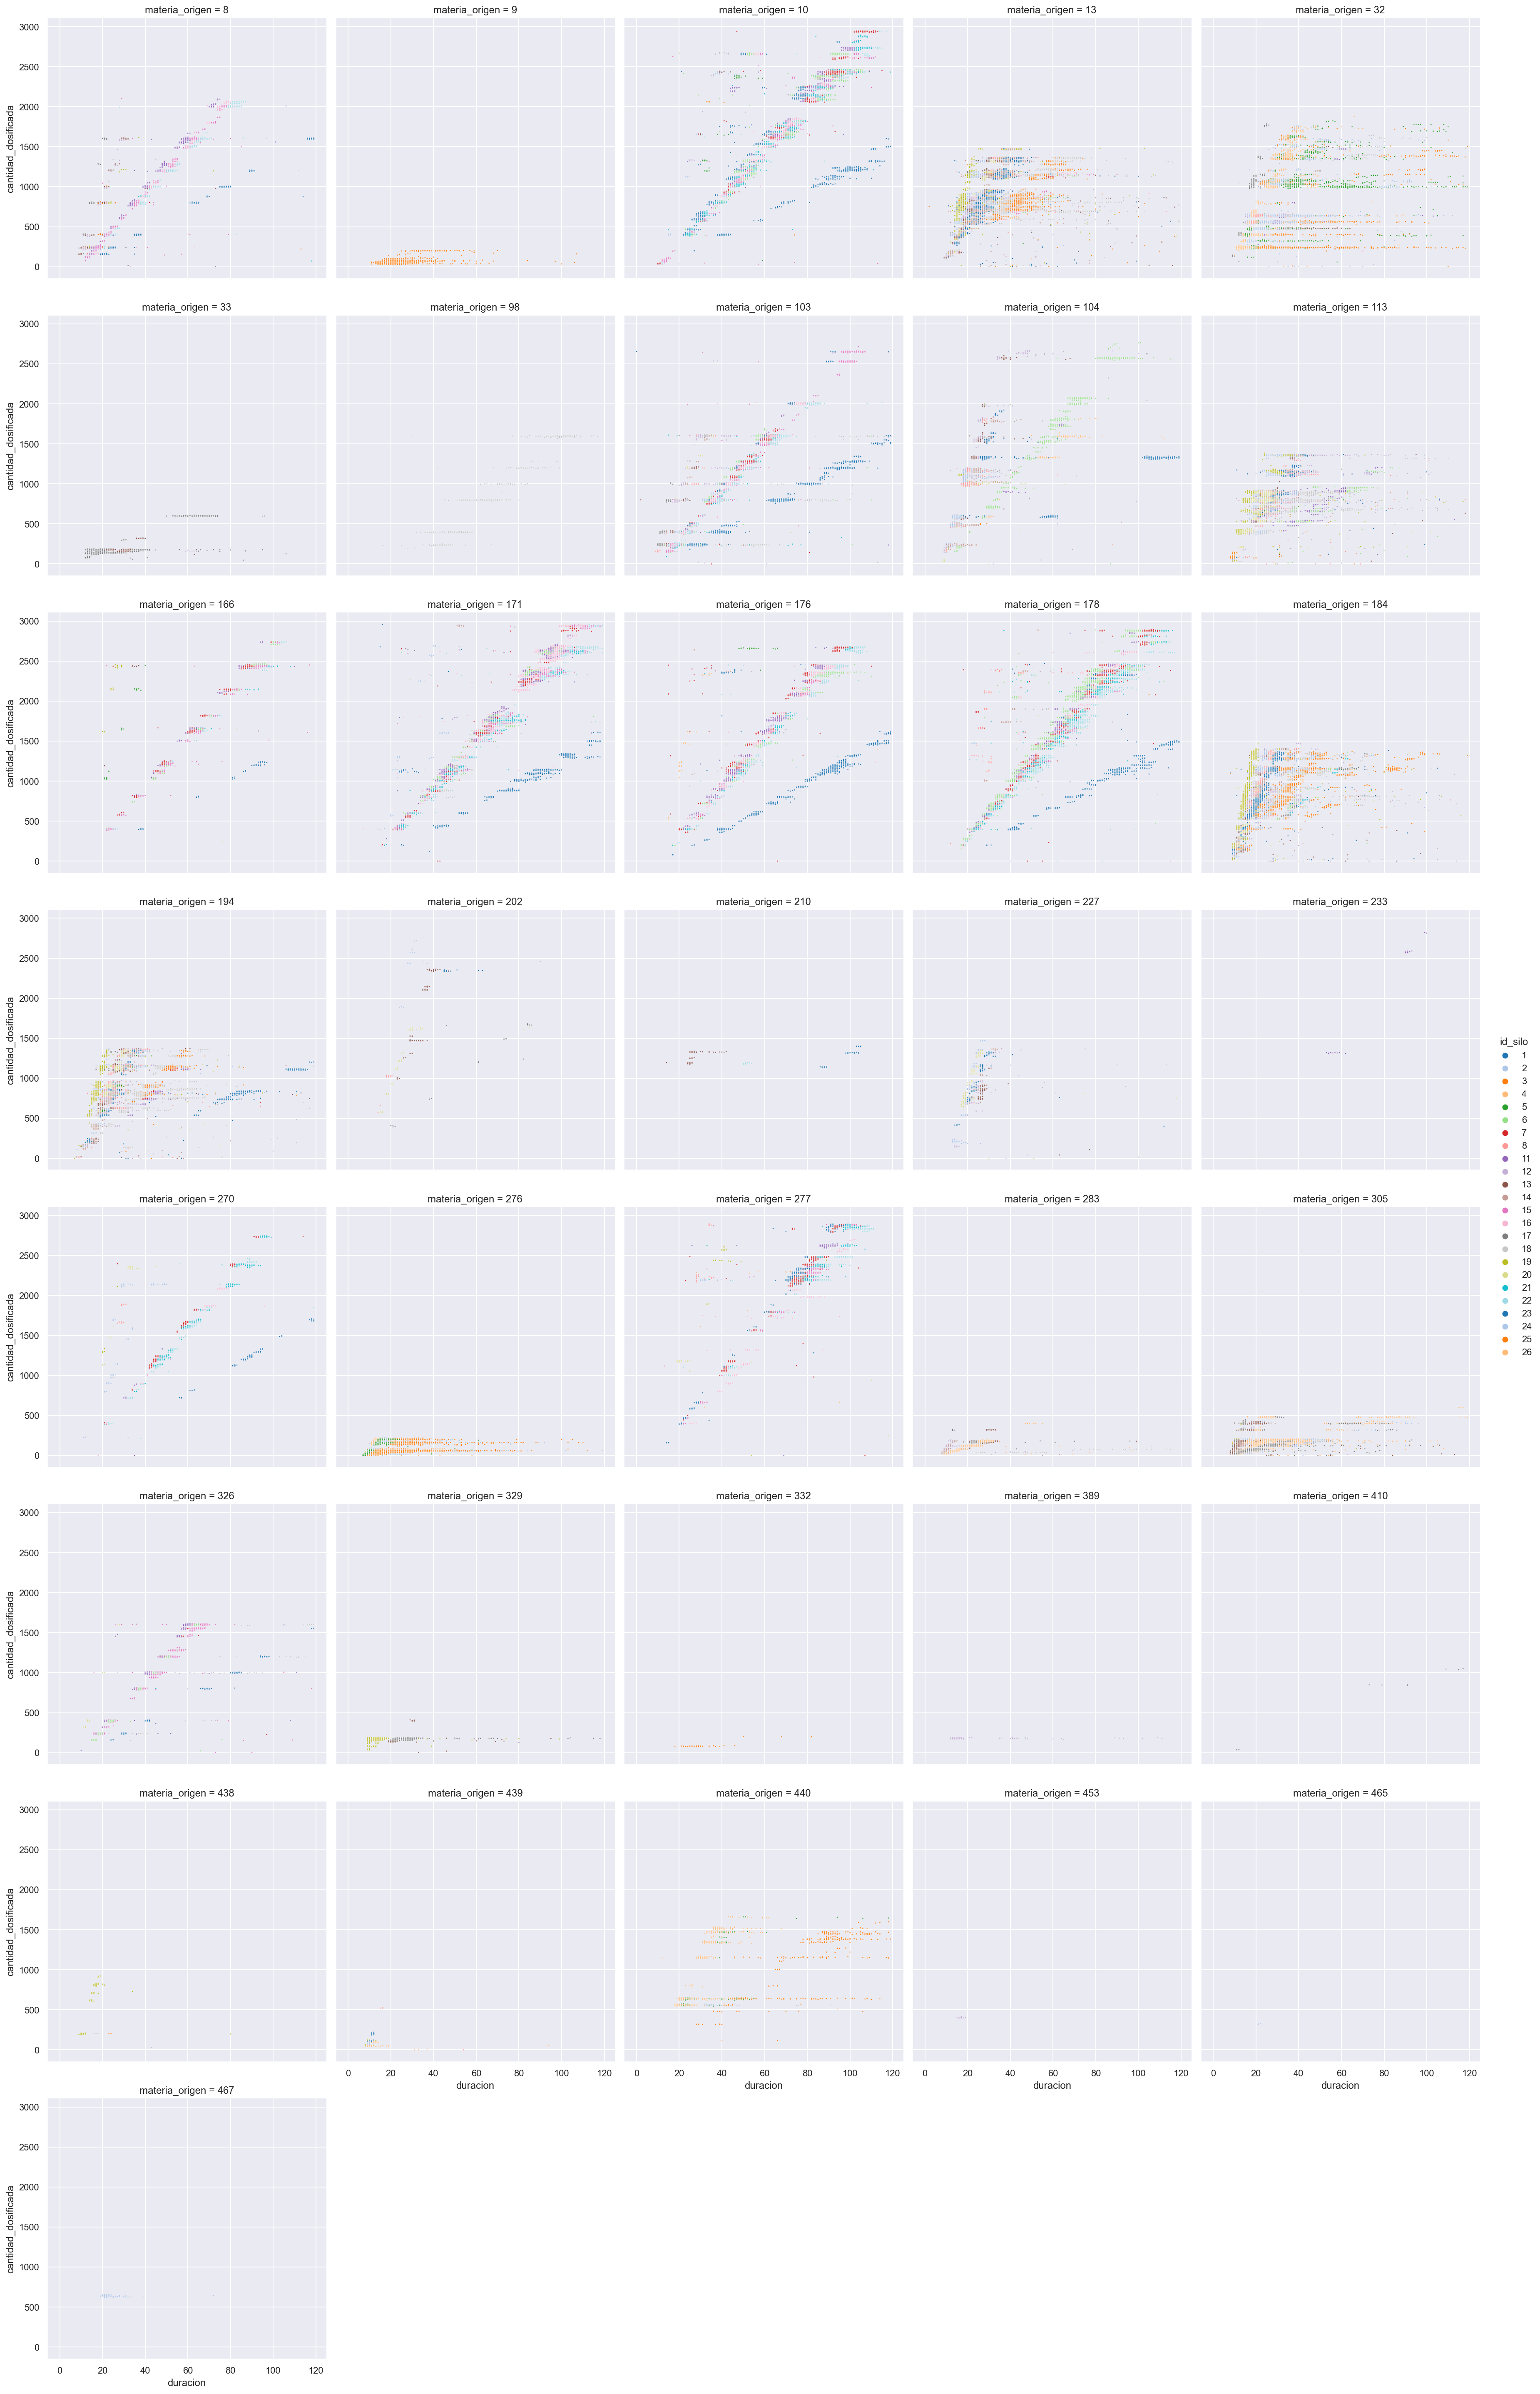

In [15]:
sns.relplot(data=df_dosificaciones, x='duracion', y='cantidad_dosificada', 
            s=2, hue='id_silo', col= 'materia_origen', col_wrap=5,  palette='tab20');

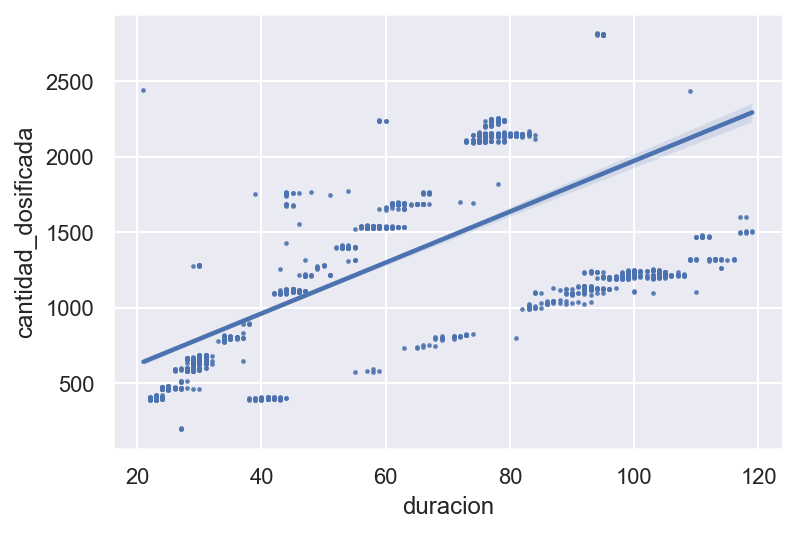

In [16]:
sns.regplot(data=df_dosificaciones[(df_dosificaciones['materia_origen']==10) & 
                                   (df_dosificaciones['id_silo']==1)], x='duracion', y='cantidad_dosificada', scatter_kws={'s':2});

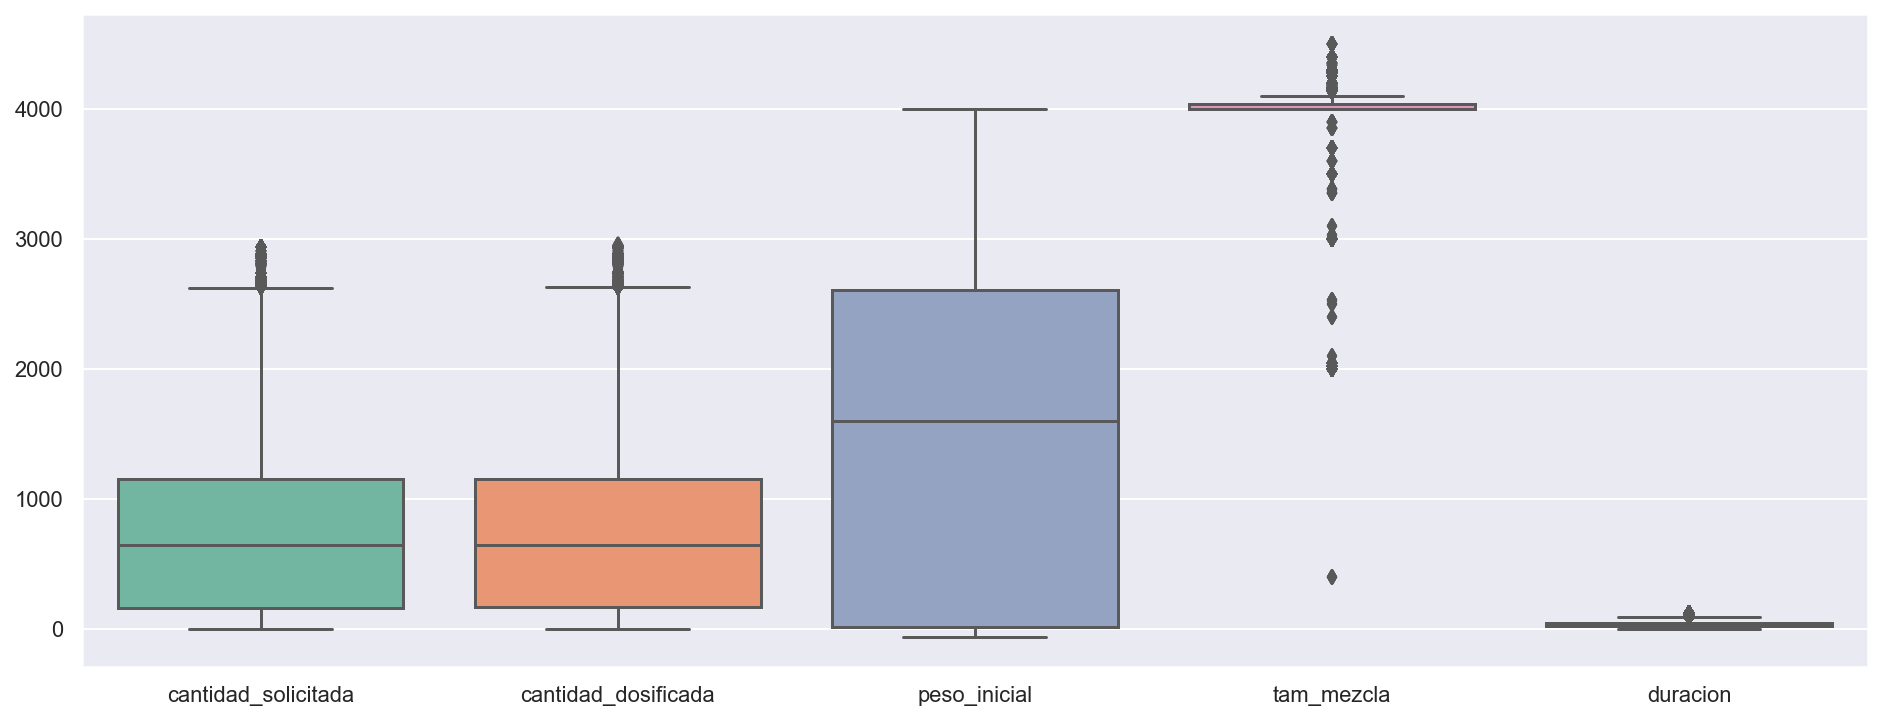

In [17]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_dosificaciones[['cantidad_solicitada','cantidad_dosificada','peso_inicial','tam_mezcla', 'duracion']], palette="Set2")

plt.show()

7.- Filtrado de los datos que pueden producir ruido

In [18]:
df_dosificaciones = df_dosificaciones[(df_dosificaciones['cantidad_solicitada'] > 0) &
                  (df_dosificaciones['cantidad_solicitada'] < 2500) &
                  (df_dosificaciones['cantidad_dosificada'] > 1) &
                  (df_dosificaciones['cantidad_dosificada'] < 3000) &
                  (df_dosificaciones['desviacion'] > -40) &
                  (df_dosificaciones['desviacion'] < 40) &
                  (df_dosificaciones['peso_inicial'] < 3000)]

In [19]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362981 entries, 1308958 to 3211250
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         362981 non-null  datetime64[ns]
 1   fecha_fin            362981 non-null  datetime64[ns]
 2   cantidad_solicitada  362981 non-null  float64       
 3   cantidad_dosificada  362981 non-null  float64       
 4   mezcla               362981 non-null  int64         
 5   pesada               362981 non-null  int64         
 6   peso_inicial         362981 non-null  int64         
 7   manual               362981 non-null  int64         
 8   id_lote_destino      362981 non-null  int64         
 9   materia_origen       362981 non-null  int64         
 10  materia_destino      362981 non-null  int64         
 11  id_silo              362981 non-null  int64         
 12  tipo_materia         362981 non-null  object        
 13  tipo_de

8.- Eliminación de columnas que no aportan información

In [22]:
columns_delete = ['fecha_fin','cantidad_dosificada', \
                  'manual','densidad','tipo_materia', \
                  'tipo_destino','id_lote_destino','desviacion','pesada']
df_dosificaciones.drop(columns=columns_delete, inplace=True)

In [25]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362981 entries, 1308958 to 3211250
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         362981 non-null  datetime64[ns]
 1   cantidad_solicitada  362981 non-null  float64       
 2   mezcla               362981 non-null  int64         
 3   peso_inicial         362981 non-null  int64         
 4   materia_origen       362981 non-null  int64         
 5   materia_destino      362981 non-null  int64         
 6   id_silo              362981 non-null  int64         
 7   tam_mezcla           362981 non-null  int64         
 8   duracion             362981 non-null  int64         
 9   orden                362981 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 30.5 MB


9.- Creo que la hora y el dia de la semana pueden influir en la predicción por lo que añado las caracteristicas.

In [26]:
#df_dosificaciones['mes'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).month
#df_dosificaciones['dia'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).day
df_dosificaciones['hora'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).hour
df_dosificaciones['dow'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).dayofweek

In [27]:
df_dosificaciones.head(5)

,fecha_inicio,cantidad_solicitada,mezcla,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow
codigo,,,,,,,,,,,,
1308958,2018-01-01 21:58:18,1600.078404,1,-12,8,285,1,4000,117,1,21,0
1308971,2018-01-01 22:01:08,180.008820,1,2799,33,285,17,4000,19,2,22,0
1308973,2018-01-01 22:02:11,768.557659,1,2,184,285,14,4000,41,1,22,0
1308975,2018-01-01 22:05:50,1600.078404,2,-21,8,285,1,4000,118,1,22,0
1308978,2018-01-01 22:07:49,1187.738199,2,1581,176,285,15,4000,46,2,22,0


10.- Carga de datos obtenidos de aemet, al ser diarios posteriormente pasaremos la fecha de los datos de las
dosificaciones tambien a fechas diarias.

In [29]:
df_meteo = pd.read_csv('datos/datosMeteo.csv', \
                    sep=',', na_values='\\N',  \
                    parse_dates=['fecha','horatmin','horatmax','horaracha'])
df_meteo.rename(columns={'fecha':'fecha_inicio'}, inplace=True)
df_meteo.head(5)

,fecha_inicio,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha
0,2018-01-01,CARTAGENA,MURCIA,17,14.1,0.0,10.8,2018-01-01 08:00:00,17.4,2018-01-01 00:10:00,19,1.7,9.7,2018-01-01 15:10:00
1,2018-01-01,SAN JAVIER AEROPUERTO,MURCIA,4,13.8,0.0,8.2,2018-01-01 22:06:00,19.3,2018-01-01 11:51:00,32,4.7,12.8,2018-01-01 00:22:00
2,2018-01-02,CARTAGENA,MURCIA,17,14.3,0.0,10.2,2018-01-02 08:00:00,18.4,2018-01-02 12:20:00,18,1.1,4.7,2018-01-02 14:50:00
3,2018-01-02,SAN JAVIER AEROPUERTO,MURCIA,4,15.4,0.0,8.0,2018-01-02 02:58:00,22.7,2018-01-02 14:28:00,30,4.7,11.7,2018-01-02 23:45:00
4,2018-01-03,CARTAGENA,MURCIA,17,16.0,0.0,11.7,2018-01-03 05:00:00,20.3,2018-01-03 15:10:00,16,0.8,6.4,2018-01-03 16:00:00


Hemos obtenido la informacion meteorologica de las dos estaciones mas cercanas a la fabrica, y mas o menos estan a la misma distancia, 
quedando etre ellas la propia fabrica, por lo que calcularemos la media de los valores de las dos.

In [30]:
df_meteo_group = df_meteo.groupby(['fecha_inicio']).mean()
df_meteo_group.head()

,altitud,tmed,prec,tmin,tmax,dir,velmedia,racha
fecha_inicio,,,,,,,,
2018-01-01,10.5,13.95,0.0,9.5,18.35,25.5,3.20,11.25
2018-01-02,10.5,14.85,0.0,9.1,20.55,24.0,2.90,8.20
2018-01-03,10.5,17.70,0.0,12.7,22.70,24.0,2.35,10.15
2018-01-04,10.5,15.85,0.0,11.0,20.70,23.0,1.70,11.25
2018-01-05,10.5,13.20,0.0,8.0,18.45,18.0,1.65,5.85


Nos quedamos solo con los datos del dia en nuestra fecha de las dosificaciones para hacer el merge con nuestra tabla de datos meteorologicos

In [31]:
df_dosificaciones['fecha_inicio'] = df_dosificaciones['fecha_inicio'].dt.normalize()

In [32]:
df_dosificaciones = pd.merge(df_dosificaciones, df_meteo_group, on='fecha_inicio')

In [33]:
df_dosificaciones.head()

,fecha_inicio,cantidad_solicitada,mezcla,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,altitud,tmed,prec,tmin,tmax,dir,velmedia,racha
0,2018-01-01,1600.078404,1,-12,8,285,1,4000,117,1,21,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
1,2018-01-01,180.008820,1,2799,33,285,17,4000,19,2,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
2,2018-01-01,768.557659,1,2,184,285,14,4000,41,1,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
3,2018-01-01,1600.078404,2,-21,8,285,1,4000,118,1,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
4,2018-01-01,1187.738199,2,1581,176,285,15,4000,46,2,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25


In [34]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362234 entries, 0 to 362233
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         362234 non-null  datetime64[ns]
 1   cantidad_solicitada  362234 non-null  float64       
 2   mezcla               362234 non-null  int64         
 3   peso_inicial         362234 non-null  int64         
 4   materia_origen       362234 non-null  int64         
 5   materia_destino      362234 non-null  int64         
 6   id_silo              362234 non-null  int64         
 7   tam_mezcla           362234 non-null  int64         
 8   duracion             362234 non-null  int64         
 9   orden                362234 non-null  int64         
 10  hora                 362234 non-null  int64         
 11  dow                  362234 non-null  int64         
 12  altitud              362234 non-null  float64       
 13  tmed          

In [35]:
columns_delete = ['fecha_inicio','altitud', \
                  'dir','velmedia','racha','prec']
df_dosificaciones.drop(columns=columns_delete, inplace=True)

In [36]:
df_dosificaciones.head()

,cantidad_solicitada,mezcla,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,tmed,prec,tmin,tmax
0,1600.078404,1,-12,8,285,1,4000,117,1,21,0,13.95,0.0,9.5,18.35
1,180.008820,1,2799,33,285,17,4000,19,2,22,0,13.95,0.0,9.5,18.35
2,768.557659,1,2,184,285,14,4000,41,1,22,0,13.95,0.0,9.5,18.35
3,1600.078404,2,-21,8,285,1,4000,118,1,22,0,13.95,0.0,9.5,18.35
4,1187.738199,2,1581,176,285,15,4000,46,2,22,0,13.95,0.0,9.5,18.35


11.- Miro la correlacion entre las variables.

In [41]:
df_dosificaciones.corr()

,cantidad_solicitada,mezcla,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,tmed,tmin,tmax
cantidad_solicitada,1.000000,-0.087585,-0.756563,-0.293747,0.088790,0.044651,0.035881,0.875799,-0.687010,0.036395,-0.015552,-0.012906,-0.010068,-0.015399
mezcla,-0.087585,1.000000,0.091262,0.027655,-0.224799,-0.033320,0.004233,-0.099576,0.101802,-0.251697,0.075586,0.041715,0.041097,0.040548
peso_inicial,-0.756563,0.091262,1.000000,0.383265,-0.086452,-0.190044,0.058435,-0.572104,0.851956,-0.043647,0.020358,0.013562,0.010766,0.016028
materia_origen,-0.293747,0.027655,0.383265,1.000000,0.007220,-0.020997,0.026870,-0.223241,0.454454,-0.023578,-0.001148,0.015731,0.021315,0.008801
materia_destino,0.088790,-0.224799,-0.086452,0.007220,1.000000,0.033009,0.011354,0.104956,-0.075709,0.089676,-0.052734,-0.074326,-0.078710,-0.066506
id_silo,0.044651,-0.033320,-0.190044,-0.020997,0.033009,1.000000,-0.012712,-0.036974,-0.240582,0.010789,-0.024455,-0.016696,-0.021258,-0.010965
tam_mezcla,0.035881,0.004233,0.058435,0.026870,0.011354,-0.012712,1.000000,0.009449,0.012628,-0.025740,0.031332,0.101712,0.100042,0.099625
duracion,0.875799,-0.099576,-0.572104,-0.223241,0.104956,-0.036974,0.009449,1.000000,-0.543281,0.035489,-0.017516,-0.018978,-0.018510,-0.018602
orden,-0.687010,0.101802,0.851956,0.454454,-0.075709,-0.240582,0.012628,-0.543281,1.000000,-0.043196,0.032860,-0.010974,-0.017362,-0.003485
hora,0.036395,-0.251697,-0.043647,-0.023578,0.089676,0.010789,-0.025740,0.035489,-0.043196,1.000000,0.047567,0.046450,0.041623,0.049785


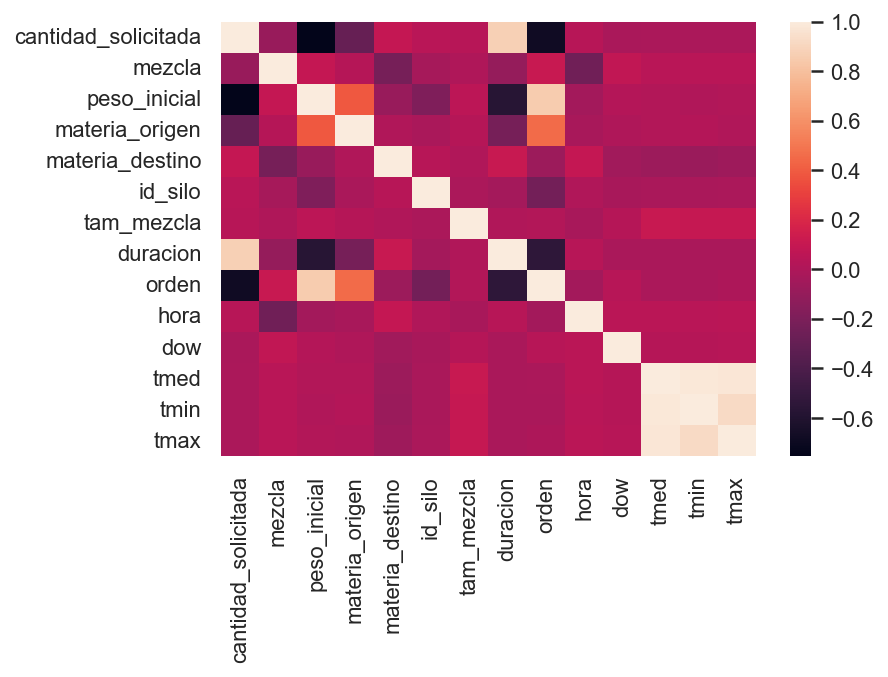

In [42]:
sns.heatmap(df_dosificaciones.corr())
plt.show()

In [24]:
var_numericas = ['cantidad_solicitada','peso_inicial', 'tam_mezcla', 'duracion']

#pg = sns.pairplot(df_dosificaciones.sample(n=10000), vars=var_numericas,  \
#                  plot_kws={'alpha':0.1,'size':.1}, \
#                  diag_kws={'bins':40})

In [25]:
#df_month_pi_des = df_dosificaciones.groupby(['materia_origen','id_silo']).mean()[['peso_inicial','desviacion']]
#df_month_pi_des.head()

In [26]:
#sns.lineplot(data=df_dosificaciones.sample(1000), x='peso_inicial', y='desviacion')

In [27]:
#!pip install sklearn

12.- Guardo los datos definitivos

In [43]:
df_dosificaciones.to_csv('datos/data_clean.zip', compression='zip')

12.- Miro los valores diferentes de las variables para ver cuales pueden ser categoricas

In [44]:
for col in df_dosificaciones:
    print(col + ": " + str(df_dosificaciones[col].nunique()))
    if (df_dosificaciones[col].nunique() < 200):
        print(df_dosificaciones[col].unique())

cantidad_solicitada: 5237
mezcla: 66
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
peso_inicial: 2842
materia_origen: 36
[  8  33 184 176 305 178 276  32   9 194 103 113 326 202  10  13 270 329
 332 277 227 166 283  98 389 171 410 210 104 233 439 440 438 467 465 453]
materia_destino: 58
[285 272 264 249  39  26 312  50  41 168 247 217  53 212  58 225 107 319
 323 321 317  48  25 314 118  49  46 215  35  61 278  62  37 310 220 291
  56 114 124 190  60 179 181 222 251 306 308 297 299 444 241 244 455 469
 472 478 484 493]
id_silo: 24
[ 1 17 14 15 13 26  7 20  2 18  8 16 25 12 23  6 24 21 19 22  3 11  4  5]
tam_mezcla: 46
[4000 4060 4040 4080 2000 2020 4010 4200  400 4100 4140 4400 4160 4150
 3030 4020 3000 3700 3500 4008 3005 3100 4250 4028 2525 4300 3380 4180
 4500 4340 4290 3600 4170 4350 2400 3350 3900 2100 2500 4280 4279 4274
 3850

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_features = ['materia_origen', 'materia_destino', 'id_silo', 'mezcla', 'orden', 'hora', 'dow']#'mes', 'dia'
num_features = ['cantidad_solicitada','peso_inicial','tam_mezcla']

num_transformer = Pipeline([('imputer',SimpleImputer()),
                            ('standard_scaler', StandardScaler())])

cat_transformer = Pipeline([('simple_imputer', SimpleImputer(strategy='constant')),
                            ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

column_trans = ColumnTransformer(
                transformers=[
                    ('num',num_transformer,num_features),
                    ('cat',cat_transformer,cat_features)])


In [68]:
from sklearn.model_selection import train_test_split

X = df_dosificaciones.drop('duracion',1)
y = df_dosificaciones['duracion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
X.head()

,cantidad_solicitada,mezcla,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,orden,hora,dow,tmed,tmin,tmax
0,1600.078404,1,-12,8,285,1,4000,1,21,0,13.95,9.5,18.35
1,180.008820,1,2799,33,285,17,4000,2,22,0,13.95,9.5,18.35
2,768.557659,1,2,184,285,14,4000,1,22,0,13.95,9.5,18.35
3,1600.078404,2,-21,8,285,1,4000,1,22,0,13.95,9.5,18.35
4,1187.738199,2,1581,176,285,15,4000,2,22,0,13.95,9.5,18.35


In [70]:
X_train_prep = column_trans.fit_transform(X_train)
X_test_prep  = column_trans.transform(X_test)

In [71]:
from sklearn.linear_model import LinearRegression

linr_model = LinearRegression()

linr_model.fit(X_train_prep, y_train)

LinearRegression()

In [72]:
from sklearn.metrics import mean_absolute_error

y_pred = linr_model.predict(X_train_prep)
y_pred_test = linr_model.predict(X_test_prep)

print("Linear regression")
print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Linear regression
Error de entrenamiento:  4.4837389272871375
Error de test:  4.520345843829766


In [73]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

lr_model = Ridge();

churn_pipe_lr = Pipeline([('prep', column_trans),
                            ('clas', lr_model)])

In [74]:
parameters = {}
parameters['prep__num__imputer__strategy'] = ['mean', 'median']
parameters['clas__alpha'] = [1,0.1,0.01,0.001,0.0001,0]

X_sample = X_train.sample(n=10000)
y_sample = y_train[X_sample.index]

GS = GridSearchCV(estimator=churn_pipe_lr, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
GS = GS.fit(X_sample, y_sample)	
    
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)


Mejor score:  -59.07789116085994
Mejore configuración de parámetros:  {'clas__alpha': 1, 'prep__num__imputer__strategy': 'mean'}


In [75]:
ridge_model = Ridge(alpha=1);

ridge_model.fit(X_train_prep, y_train) 

Ridge(alpha=1)

In [76]:
y_pred = ridge_model.predict(X_train_prep)
y_pred_test = ridge_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Error de entrenamiento:  4.491885558564014
Error de test:  4.528801974773755


In [77]:
import pickle
nombre_modelo = 'modelo_ridge.pkl'

pickle.dump(ridge_model, open(nombre_modelo,'wb'))

In [78]:
loaded_model = pickle.load(open(nombre_modelo, 'rb'))

In [79]:
y_pred = loaded_model.predict(X_test_prep)

In [81]:
print("Ridge")
print("Error de entrenamiento: ", mean_absolute_error(y_test, y_pred))

Ridge
Error de entrenamiento:  4.528801974773755


In [82]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

from sklearn.ensemble import RandomForestRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('prep', column_trans),
                ('modelo',  RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 200, 1000],
    'modelo__max_features': ["auto", 3, 5, 7, 10],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

In [83]:
X_sample = X_train.sample(n=1000)
y_sample = y_train[X_sample.index]

In [84]:
grid.fit(X = X_sample, y = y_sample)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = True)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
14,50,3,3,-20.835993,1.271058,-20.658009,0.702094


In [85]:
print("Mejor score: ", grid.best_score_)
print("Mejore configuración de parámetros: ", grid.best_params_)

Mejor score:  -8.22278929684858
Mejore configuración de parámetros:  {'modelo__n_estimators': 200, 'modelo__max_features': 'auto', 'modelo__max_depth': 20}


In [ ]:
rf_model = RandomForestRegressor(n_estimators=200,max_features='auto',max_depth=20)

rf_model.fit(X_train_prep, y_train)

In [58]:
y_pred = rf_model.predict(X_train_prep)
y_pred_test = rf_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Error de entrenamiento:  41.9157143986831
Error de test:  42.79118013855667
